In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import datasets, transforms 
from torchvision.models import resnet18
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import cv2
import os

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

In [ ]:
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(download=True, root=".", transform=data_transform, train=True)
test_dataset = MNIST(download=True, root=".", transform=data_transform, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 317611868.85it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41584515.56it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 90908858.32it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11239250.01it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [ ]:
def setup_dataflow(dataset, train_idx, val_idx):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    return train_loader, val_loader

In [ ]:
num_folds = 3
splits = KFold(n_splits=num_folds,shuffle=True,random_state=42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

############### Fold 1 ###############
Epochs: 0, Train_loss: 0.12574275708556268, Valid_loss: 0.056396501270850025, Train_accuracy: 98.98855697938542, Valid_accuracy: 98.22147938630324
Epochs: 1, Train_loss: 0.04047534989684276, Valid_loss: 0.045808930038626, Train_accuracy: 99.37213388762697, Valid_accuracy: 98.56861232536214
Epochs: 2, Train_loss: 0.02862275890348354, Valid_loss: 0.034873955636121785, Train_accuracy: 99.7064243774911, Valid_accuracy: 98.92003085626125
Epochs: 3, Train_loss: 0.02043365682041205, Valid_loss: 0.04481432034820637, Train_accuracy: 99.48999271418162, Valid_accuracy: 98.73146481529099
Epochs: 4, Train_loss: 0.019109763520869873, Valid_loss: 0.04299878791880723, Train_accuracy: 99.60142287746969, Valid_accuracy: 98.76574955001286
Epochs: 5, Train_loss: 0.015283483441932673, Valid_loss: 0.04895800935882518, Train_accuracy: 99.34641923456049, Valid_accuracy: 98.5643267335219
Epochs: 6, Train_loss: 0.01228239246170205, Valid_loss: 0.03745710849169421, Train_ac

<ipython-input-11-43f6c9b08499>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.13323983608087878, Valid_loss: 0.05977581717019696, Train_accuracy: 98.82357983157263, Valid_accuracy: 98.2899755710796
Epochs: 1, Train_loss: 0.04173112174319237, Valid_loss: 0.05235447815046502, Train_accuracy: 99.12572053056763, Valid_accuracy: 98.42283461192302
Epochs: 2, Train_loss: 0.029115860929045678, Valid_loss: 0.04402234315242672, Train_accuracy: 99.40428996935736, Valid_accuracy: 98.74855355076501
Epochs: 3, Train_loss: 0.021105628651391463, Valid_loss: 0.057553385123141544, Train_accuracy: 99.18357726016242, Valid_accuracy: 98.46997814254489
Epochs: 4, Train_loss: 0.018292753372165634, Valid_loss: 0.032077251860292026, Train_accuracy: 99.75357318876293, Valid_accuracy: 99.04855783654052
Epochs: 5, Train_loss: 0.017708833359181563, Valid_loss: 0.03924191987940528, Train_accuracy: 99.68928793365762, Valid_accuracy: 98.92855612223032
Epochs: 6, Train_loss: 0.011378845285378988, Valid_loss: 0.0426024171615696, Train_accuracy: 99.66143098977864, Valid_a

<ipython-input-11-43f6c9b08499>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epochs: 0, Train_loss: 0.12934180993090158, Valid_loss: 0.05045154055074967, Train_accuracy: 99.12143484689395, Valid_accuracy: 98.42712038743412
Epochs: 1, Train_loss: 0.039750927330048674, Valid_loss: 0.038942980873382535, Train_accuracy: 99.55428889793644, Valid_accuracy: 98.78283975485364
Epochs: 2, Train_loss: 0.027590570080142235, Valid_loss: 0.04202267120866191, Train_accuracy: 99.64000257141021, Valid_accuracy: 98.8299832854755
Epochs: 3, Train_loss: 0.023716380772596527, Valid_loss: 0.053493365188558226, Train_accuracy: 99.43643259691002, Valid_accuracy: 98.57283675481078
Epochs: 4, Train_loss: 0.01716270620674626, Valid_loss: 0.053853072131190956, Train_accuracy: 99.38500439282578, Valid_accuracy: 98.42283461192302
Epochs: 5, Train_loss: 0.014537659332115309, Valid_loss: 0.04013667025393971, Train_accuracy: 99.81142991835773, Valid_accuracy: 98.9328418977414
Epochs: 6, Train_loss: 0.010543287226359674, Valid_loss: 0.051681123160218306, Train_accuracy: 99.50500353568903, Valid

<ipython-input-11-43f6c9b08499>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


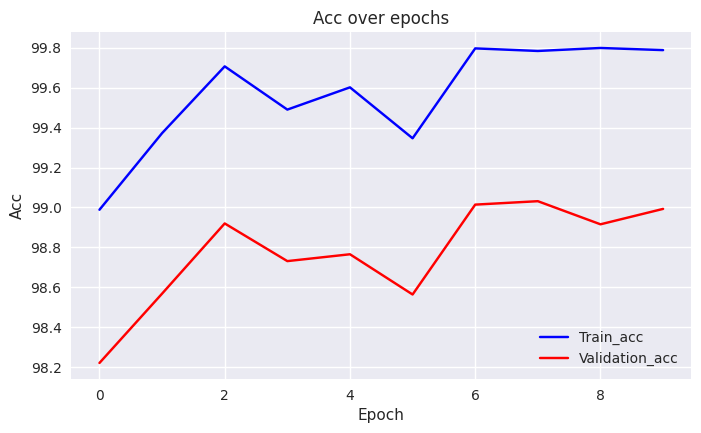

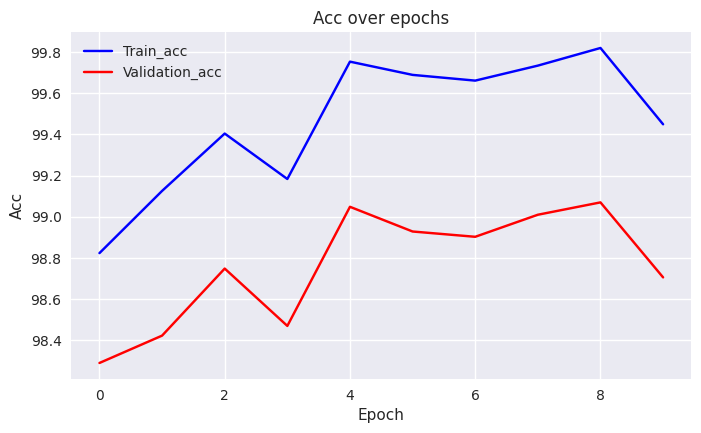

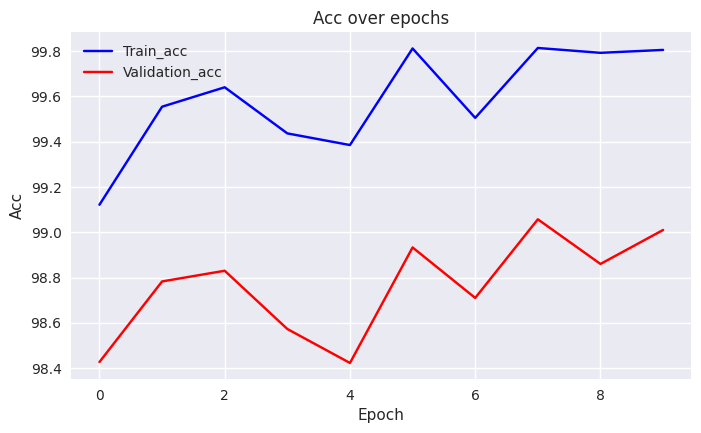

In [ ]:
for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
  print('############### Fold {} ###############'.format(fold_idx + 1))
  train_loader, val_loader = setup_dataflow(dataset, train_idx, val_idx)
  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  loss_function = nn.CrossEntropyLoss()
  model, optimizer, _ = training_loop(model, loss_function, optimizer, train_loader, val_loader, 10, device)
